# Sparkify: Churn Reduction

## 0. Overview

This project focuses on a fictional music streaming service called 'Sparkify', which provides music streaming in a similar manner to services such as Spotify or Pandora.

The project aims to identify customers who are most likely to quit using the service, and thereby target such customers to reduce churn. It makes use of a fictional but representative customer data set to do this. In many respects this problem (churn prediction and ultimately reduction) is a fairly classic data science use case, but this project aims to tackle the problem using Spark and its scalable ML capabilities. 

We'll follow a number of steps to tackle this project:
- Load and perform initial cleaning of the dataset
- Explore the data and attempt to identify useful features
- Build features and prepare for modelling
- Model the data and evaluate results

We will test multiple predictive models to try and predict churn, and will use an f1 score to evaluate them (given we have an unbalanced data set, as is typical in churn reduction problems).

The data in question takes the form of user logs. This workspace makes use of a small subset (128MB) of the full dataset available (12GB), and aims to prototype the models cheaply. The full dataset can be made use of separately in AWS. 

## 1. Set-up

In [359]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, count, isnull, when
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

In [220]:
# configure library settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 200)

%matplotlib inline

In [221]:
# create a Spark session
spark = (SparkSession
         .builder
         .appName('Customer Churn')
         .getOrCreate())

## 2. Load and Clean Dataset

Here we'll load the data, and perform some basic cleaning to prepare it for exploration. We begin by loading the initial data from a JSON file.

In [222]:
# create dataframe from log data and persist the rdd
path = 'mini_sparkify_event_data.json'
raw_logs_df = spark.read.json(path)
raw_logs_df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [223]:
# print schema
raw_logs_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [224]:
# print shape of the dataframe
print((raw_logs_df.count(), len(raw_logs_df.columns)))

(286500, 18)


In [225]:
# print header to observe data
raw_logs_df.show(10, truncate = False)

+-----------------------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+---------------+-------------+---------+------------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist                       |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page           |registration |sessionId|song                          |status|ts           |userAgent                                                                                                      |userId|
+-----------------------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+---------------+-------------+---------+------------------------------+------+-------------+-------------------------------------------------------------------------------

In [226]:
# optionally, perform the same operation in a more readable format
raw_logs_df.limit(10).toPandas().head(10)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36""",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0,30


Next, we'll drop observations with null fields in key areas - notably User IDs or Session IDs. While we can make use of observations with missing values in other areas, we cannot do so when session IDs or user IDs are missing or invalid. Let's first print how many null fields are present in each.

In [227]:
# print nulls for session ID
raw_logs_df.filter(raw_logs_df['sessionId'].isNull()).count()

0

In [228]:
# print nulls for user ID
raw_logs_df.filter(raw_logs_df['UserId'].isNull()).count()

0

In [229]:
# print blanks for session ID
raw_logs_df.filter((raw_logs_df['sessionId'] == '')).count()

0

In [230]:
# print blanks for user ID
raw_logs_df.filter((raw_logs_df['UserId'] == '')).count()

8346

We can see from this that there in fact technically *aren't* null values for either of these fields. However, there *are* missing values for UserId, which amounts to the same thing in practice. We might speculate that these missing values reflect users who aren't logged into the service, or perhaps some other error in capturing IDs. In any case, we should drop these rows before moving on.

In [231]:
# remove blank userID rows
cleaned_logs_df = raw_logs_df.filter(raw_logs_df['userId'] != '')

In [232]:
# print shape of the dataframe
print((cleaned_logs_df.count(), len(cleaned_logs_df.columns)))

(278154, 18)


In [233]:
# print removed rows
print(raw_logs_df.count() - cleaned_logs_df.count())

8346


Our dataframe has reduced by the expected size, indicating that the cleaning was successful. For completeness, let's print nulls for all columns at this stage. 

In [234]:
# print nulls across fields
cleaned_logs_df.select([count(when(isnull(c), c)).alias(c) for c in cleaned_logs_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



We can see there are large numbers of nulls on artist, length, and song. These features all relate to the song being played specifically (as opposed to the user or the session), and it's not surprising they're missing for the same observations. At this stage, we'll leave these null observations in the data set, since the session data may still be usable (e.g. for assessment of customer behaviour for which specific song detail isn't required). 

## 3. Exploratory Data Analysis

Let's now begin to do some EDA on the dataset. We'll first identify, define, and explore churn, before beginning to perform some initial analyses aimed at identifying features.

### 3.1 Define Churn

In [235]:
# print available pages visited in a session
cleaned_logs_df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Having printed the available events that can affect a user, we'll define a user as having churned when we see a "Cancellation Confirmation" event. This event implies a user has actively aimed to cancel, and done so successfully - regardless of whether they are premium or free tier.

We'll now establish a flag to capture these events. We'll do this by adding a pipeline to look for churned users and then append a flag to the dataframe when the relevant event is seen.

In [236]:
# return user IDs of users who have churned
churn_flag_bucket = (cleaned_logs_df.filter(cleaned_logs_df.page == 'Cancellation Confirmation')
                       .select('userId')
                       .distinct()                        
                       .rdd.flatMap(lambda x: x)
                       .collect())

In [237]:
# create column using this churn flag
cleaned_logs_df = cleaned_logs_df.withColumn\
                ('Churn_Flag', when(cleaned_logs_df.userId.isin(churn_flag_bucket), 1).otherwise(0))

We can see in the dataframe header below that we have successfully identified some churned users in our dataframe.

In [238]:
# print list of entries to observe churn flag 
cleaned_logs_df.select(['userId', 'Churn_Flag']).show(100)

+------+----------+
|userId|Churn_Flag|
+------+----------+
|    30|         0|
|     9|         0|
|    30|         0|
|     9|         0|
|    30|         0|
|     9|         0|
|     9|         0|
|    30|         0|
|    30|         0|
|    30|         0|
|     9|         0|
|     9|         0|
|    30|         0|
|     9|         0|
|     9|         0|
|    30|         0|
|     9|         0|
|    74|         0|
|    30|         0|
|     9|         0|
|    74|         0|
|    30|         0|
|    54|         1|
|     9|         0|
|    74|         0|
|    30|         0|
|    54|         1|
|     9|         0|
|    74|         0|
|    30|         0|
|    54|         1|
|     9|         0|
|    30|         0|
|    74|         0|
|    54|         1|
|    54|         1|
|    30|         0|
|     9|         0|
|    30|         0|
|    54|         1|
|    74|         0|
|     9|         0|
|    74|         0|
|    54|         1|
|    54|         1|
|    30|         0|
|     9|         0|


In case it proves useful later on in our analysis, we'll also add a flag for downgrade events.

In [239]:
# return user IDs of users who have downgraded
downgrade_flag_bucket = (cleaned_logs_df.filter(cleaned_logs_df.page == 'Submit Downgrade')
                       .select('userId')
                       .distinct()                        
                       .rdd.flatMap(lambda x: x)
                       .collect())

In [240]:
# create column using downgrade flag
cleaned_logs_df = cleaned_logs_df.withColumn\
                ('Downgrade_Flag', when(cleaned_logs_df.userId.isin(downgrade_flag_bucket), 1).otherwise(0))

In [241]:
# print list of entries to observe churn flag 
cleaned_logs_df.select(['userId', 'Churn_Flag', 'Downgrade_Flag']).show(100)

+------+----------+--------------+
|userId|Churn_Flag|Downgrade_Flag|
+------+----------+--------------+
|    30|         0|             1|
|     9|         0|             1|
|    30|         0|             1|
|     9|         0|             1|
|    30|         0|             1|
|     9|         0|             1|
|     9|         0|             1|
|    30|         0|             1|
|    30|         0|             1|
|    30|         0|             1|
|     9|         0|             1|
|     9|         0|             1|
|    30|         0|             1|
|     9|         0|             1|
|     9|         0|             1|
|    30|         0|             1|
|     9|         0|             1|
|    74|         0|             1|
|    30|         0|             1|
|     9|         0|             1|
|    74|         0|             1|
|    30|         0|             1|
|    54|         1|             1|
|     9|         0|             1|
|    74|         0|             1|
|    30|         0| 

Before moving on, let's review how large the pool of churned customers is. 

In [242]:
# show churn numbers in tabular format
churn_summary = cleaned_logs_df.dropDuplicates(['userId']).groupby(['Churn_Flag']).count()
churn_summary.show()

+----------+-----+
|Churn_Flag|count|
+----------+-----+
|         1|   52|
|         0|  173|
+----------+-----+



<BarContainer object of 2 artists>

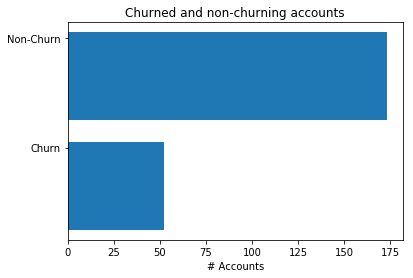

In [243]:
# show churn numbers in a simple bar charts
churn_accounts = churn_summary.select('count').collect()[0][0]
non_churn_accounts = churn_summary.select('count').collect()[1][0]

N = 2
churn_values = (churn_accounts, non_churn_accounts)
ind = np.arange(N)
width = 0.35
plt.title('Churned and non-churning accounts')
plt.yticks(ind + width, ('Churn', 'Non-Churn'))
plt.xlabel('# Accounts')
plt.barh(ind, churn_values)

We can see that almost a quarter of the accounts in the data set have churned - quite a high proportion. Let's now explore potential causes of this further.

In [244]:
# save new dataframe for further exploration of data
logs_df = cleaned_logs_df

### 3.2 Explore Data

Now that we've defined a churn measure, we'll perform some exploratory data analysis to build intuition on what features might be predictive of churn.

We'll use insights from this exercise to inform our feature selection later on. 

To recap, we saw a number of interaction attributes earlier on (re-pasted below). We'll consider these as well as relevant information about users (e.g. gender).

In [245]:
# print potential page interactions
logs_df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



#### 3.2.1 Number of songs played

In [246]:
# print songs played by churn category
logs_df.select('userId', 'Churn_Flag', 'song').groupby('userId', 'Churn_Flag').agg({'song':'count'})\
            .groupby('Churn_Flag').agg({'count(song)':'avg'}).show()

+----------+------------------+
|Churn_Flag|  avg(count(song))|
+----------+------------------+
|         1| 699.8846153846154|
|         0|1108.1734104046243|
+----------+------------------+



The difference in song counts between churning and non-churning users is quite material, and suggests this is a feature worth considering.

#### 3.2.2 Songs added to playlist

In [247]:
# print songs added to playlist by churn category
logs_df.select('userId', 'Churn_Flag', 'page').where(logs_df['page']=='Add to Playlist')\
        .groupby('userId', 'Churn_Flag').agg({'page':'count'}).groupby('Churn_Flag').agg({'count(page)':'avg'}).show()

+----------+-----------------+
|Churn_Flag| avg(count(page))|
+----------+-----------------+
|         1|            20.76|
|         0|33.26060606060606|
+----------+-----------------+



As perhaps expected, churned users tend to have added fewer songs to the playlist on average. This suggests that such users may be less engaged, and implies this is a useful variable to include in our analysis.

#### 3.2.3 Sentiment: Thumbs up or thumbs down

In [248]:
# build dataframe for thumbs up entries
thumbs_up_df = logs_df.select('userId', 'Churn_Flag', 'page').where(logs_df['page']=='Thumbs Up')\
        .groupby('userId', 'Churn_Flag').agg({'page':'count'}).groupby('Churn_Flag').agg({'count(page)':'avg'})\
        .withColumnRenamed('avg(count(page))', 'Thumbs up average')

In [249]:
# build dataframe for thumbs down entries
thumbs_down_df = logs_df.select('userId', 'Churn_Flag', 'page').where(logs_df['page']=='Thumbs Down')\
        .groupby('userId', 'Churn_Flag').agg({'page':'count'}).groupby('Churn_Flag').agg({'count(page)':'avg'})\
        .withColumnRenamed('avg(count(page))', 'Thumbs down average')

In [250]:
# print thumbs up and thumbs down by churn category
thumbs_up_df.join(thumbs_down_df, 'Churn_Flag').show()

+----------+-----------------+-------------------+
|Churn_Flag|Thumbs up average|Thumbs down average|
+----------+-----------------+-------------------+
|         1|            37.18| 10.333333333333334|
|         0|62.89411764705882| 13.225806451612904|
+----------+-----------------+-------------------+



Observationally, it looks as if churning users are more likely to express negative sentiment here. About 21% of the total 'thumbs' are 'thumbs down' for churning users. Meanwhile, the same number is about 19% for non-churning users. 

#### 3.2.4 Social activity: Adding friends

Adding friends is one signifier of how engaged someone is with the service. Let's use this now to identify whether this appears associated with churned accounts.

In [251]:
# print adding friend count averages by churn category
logs_df.select('userId', 'Churn_Flag', 'page').where(logs_df['page']=='Add Friend')\
        .groupby('userId','Churn_Flag').agg({'page':'count'}).groupby('Churn_Flag').agg({'count(page)':'avg'}).show()

+----------+------------------+
|Churn_Flag|  avg(count(page))|
+----------+------------------+
|         1|14.454545454545455|
|         0| 22.47530864197531|
+----------+------------------+



Churning users seem distinctly less social on the platform than non-churning users. As with songs added to playlist, this potentially indicates that such users are less engaged with the platform. It appears to be a useful predictor of churn and should be included in our model later on.

#### 3.2.5 Gender differences

It's possible gender could have an impact on churn - perhaps men have a higher propensity to churn, or vice versa.. We therefore look to explore this variable too.

In [252]:
# print gender by churn types
gender_churn_summary = logs_df.dropDuplicates(['userId']).groupby(['gender', 'Churn_Flag']).count()
gender_churn_summary.show()

+------+----------+-----+
|gender|Churn_Flag|count|
+------+----------+-----+
|     M|         1|   32|
|     F|         0|   84|
|     F|         1|   20|
|     M|         0|   89|
+------+----------+-----+



In [253]:
# save down values
male_churn = gender_churn_summary.select('count').collect()[0][0]
male_non_churn = gender_churn_summary.select('count').collect()[3][0]
female_churn = gender_churn_summary.select('count').collect()[2][0]
female_non_churn = gender_churn_summary.select('count').collect()[1][0]

male_total = male_churn + male_non_churn
female_total = female_churn + female_non_churn

In [254]:
# print churn rates
print("Male churn rate:", male_churn / male_total)
print("Female churn rate: ", female_churn / female_total)

Male churn rate: 0.2644628099173554
Female churn rate:  0.19230769230769232


Text(0.5, 1.0, 'Churn rate by gender')

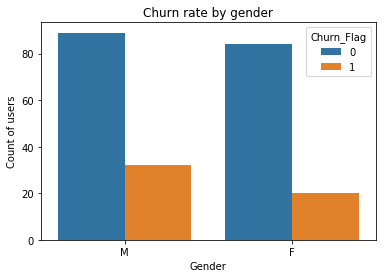

In [255]:
# visualise churn by gender
gender_churn_df = logs_df.select('userId','gender','Churn_Flag').dropDuplicates().toPandas()
sns.countplot(x='gender',hue='Churn_Flag',data=gender_churn_df)
plt.xlabel("Gender")
plt.ylabel("Count of users")
plt.title("Churn rate by gender")

We can see from this that more male customers in the data sample churn more often than female customers (~26% vs ~19%). This suggests that gender will also be a useful feature to include in our assessment.

We've now explored a number of potentially interesting features, and have built some intuition on our data set that will be useful as we move onto modelling.

## 4. Feature Engineering

In this section we'll aim to build out features that will be useful to train the model on, based on the preceding exploration. 

To do this, we'll write code to extract features from this small subset of the data.

We'll make use of seven features here, based on our exploration above:
- Total Number of songs played
- Average number of songs played per session
- Number of songs added to playlist
- Thumb up
- Thumbs down
- Number of friends added
- Gender

#### 4.1 Number of songs played

In [256]:
# build songs played feature
feature_1 = logs_df.where('page == "NextSong"').groupby(['userId']).count()\
    .groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'Songs played')

In [257]:
# print songs played feature summary
feature_1.describe('Songs played').show()

+-------+------------------+
|summary|      Songs played|
+-------+------------------+
|  count|               225|
|   mean|1013.8133333333334|
| stddev|1104.9607785540886|
|    min|               3.0|
|    max|            8002.0|
+-------+------------------+



#### 4.2 Songs played per session

In [258]:
# build songs played per session feature
feature_2 = logs_df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count() \
    .groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'Songs per session')

In [259]:
# print songs played per session feature summary
feature_2.describe('Songs per session').show()

+-------+-----------------+
|summary|Songs per session|
+-------+-----------------+
|  count|              225|
|   mean|70.78971233958933|
| stddev| 42.6153697543817|
|    min|              3.0|
|    max|286.6666666666667|
+-------+-----------------+



#### 4.3 Songs added to playlist

In [260]:
# build songs added to playlist feature
feature_3 = logs_df.where('page == "Add to Playlist"').groupby(['userId']).count()\
    .groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'Songs added to playlist')

In [261]:
# print songs added to playlist feature summary
feature_3.describe('Songs added to playlist').show()

+-------+-----------------------+
|summary|Songs added to playlist|
+-------+-----------------------+
|  count|                    215|
|   mean|      30.35348837209302|
| stddev|       32.8520568555997|
|    min|                    1.0|
|    max|                  240.0|
+-------+-----------------------+



#### 4.4 Thumbs up

In [262]:
# build thumbs up feature
feature_4 = logs_df.where('page == "Thumbs Up"').groupby(['userId']).count()\
    .groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'Thumbs up')

In [263]:
# print thumbs up feature summary
feature_4.describe('Thumbs up').show()

+-------+-----------------+
|summary|        Thumbs up|
+-------+-----------------+
|  count|              220|
|   mean|            57.05|
| stddev|65.67028650524044|
|    min|              1.0|
|    max|            437.0|
+-------+-----------------+



#### 4.5 Thumbs down

In [264]:
# build thumbs down feature
feature_5 = logs_df.where('page == "Thumbs Down"').groupby(['userId']).count()\
    .groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'Thumbs down')

In [265]:
# print thumbs down feature summary
feature_5.describe('Thumbs down').show()

+-------+------------------+
|summary|       Thumbs down|
+-------+------------------+
|  count|               203|
|   mean|12.541871921182265|
| stddev|13.198108566983787|
|    min|               1.0|
|    max|              75.0|
+-------+------------------+



#### 4.6 Number of friends added

In [266]:
# build friends added feature
feature_6 = logs_df.where('page == "Add Friend"').groupby(['userId']).count()\
    .groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'Friends added')

In [267]:
# print friends added feature summary
feature_6.describe('Friends added').show()

+-------+------------------+
|summary|     Friends added|
+-------+------------------+
|  count|               206|
|   mean|20.762135922330096|
| stddev|20.646779074405007|
|    min|               1.0|
|    max|             143.0|
+-------+------------------+



#### 4.7 Gender

In [268]:
# build gender feature with m/f as a binary value
feature_7 = logs_df.dropDuplicates(['userId']).sort('userId').select(['userId','gender'])
feature_7 = feature_7.replace(['F','M'], ['1', '0'], 'gender')

In [269]:
# convert feature type to integer
feature_7 = feature_7.withColumn('gender', feature_7.gender.cast("int"))

In [270]:
# print gender feature summary
feature_7.describe('gender').show()

+-------+-------------------+
|summary|             gender|
+-------+-------------------+
|  count|                225|
|   mean| 0.4622222222222222|
| stddev|0.49968243883744773|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



#### 4.8 Combine features ready for use

We'll now take our list of features, and join them into a dataframe for each user alongside the Churn Flag, such that we can use them for modelling. 

In [271]:
# set up features_df with user IDs
features_df = logs_df.dropDuplicates(['userId']).sort('userId').select(['userId', 'Churn_Flag'])

# pull features into an array
feature_list = [feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7]

# join features onto dataframe
for feature in feature_list:
    features_df = features_df.join(feature,'userId')

In [272]:
# rename churn_flag to label for ease of use in modelling
features_df = features_df.withColumnRenamed('Churn_Flag', 'label')

# drop user_id
features_df = features_df.drop('userID') 

# ensure NAs filled
features_df = features_df.fillna(0)

In [273]:
features_df.show()

+-----+------------+------------------+-----------------------+---------+-----------+-------------+------+
|label|Songs played| Songs per session|Songs added to playlist|Thumbs up|Thumbs down|Friends added|gender|
+-----+------------+------------------+-----------------------+---------+-----------+-------------+------+
|    0|       275.0|39.285714285714285|                    7.0|     17.0|        5.0|          4.0|     1|
|    0|       387.0|              64.5|                    8.0|     21.0|        6.0|          4.0|     0|
|    1|      2111.0|             211.1|                   52.0|    100.0|       21.0|         28.0|     0|
|    0|      4079.0|145.67857142857142|                  118.0|    171.0|       41.0|         74.0|     1|
|    0|       150.0|21.428571428571427|                    5.0|      7.0|        1.0|          1.0|     0|
|    1|      2841.0| 81.17142857142858|                   72.0|    163.0|       29.0|         33.0|     1|
|    0|      1914.0|136.7142857142857

In [274]:
# optionally, perform the same operation in a more readable format
features_df.limit(10).toPandas().head(10)

,label,Songs played,Songs per session,Songs added to playlist,Thumbs up,Thumbs down,Friends added,gender
0,0,275.0,39.285714,7.0,17.0,5.0,4.0,1
1,0,387.0,64.500000,8.0,21.0,6.0,4.0,0
2,1,2111.0,211.100000,52.0,100.0,21.0,28.0,0
3,0,4079.0,145.678571,118.0,171.0,41.0,74.0,1
4,0,150.0,21.428571,5.0,7.0,1.0,1.0,0
5,1,2841.0,81.171429,72.0,163.0,29.0,33.0,1
6,0,1914.0,136.714286,59.0,81.0,14.0,31.0,0
7,0,820.0,136.666667,24.0,58.0,3.0,11.0,1
8,0,1928.0,120.500000,38.0,96.0,17.0,41.0,1
9,1,257.0,42.833333,7.0,17.0,3.0,6.0,0


## 5. Modeling

We'll now prepare our data for modelling and train some classifiers to predict churn. Since we have an imbalanced data set, we'll use F1 score as our evaluation metric.

#### 5.1 Prep data

We'll start by preparing our data for modelling. We'll use a fairly conventional 60/20/20 split for our train/validation/test data sets.

In [275]:
# select columns to use as features
feature_cols = features_df.columns[1:]

In [276]:
feature_cols

['Songs played',
 'Songs per session',
 'Songs added to playlist',
 'Thumbs up',
 'Thumbs down',
 'Friends added',
 'gender']

In [277]:
# vectorize columns
assembler = VectorAssembler(inputCols=feature_cols, outputCol='Features')
features_df = assembler.transform(features_df)

In [278]:
# scale features
scaler = StandardScaler(inputCol='Features', outputCol='Scaled_Features')
scaled_model = scaler.fit(features_df)
features_df = scaled_model.transform(features_df)

In [279]:
# split into train, validation, and test sets
train, non_train = features_df.randomSplit([0.6, 0.4], seed = 42)
test, validation = non_train.randomSplit([0.5, 0.5], seed = 42)

In [280]:
# instantiate evaluator
mc_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')

#### 5.2.1 Modelling: Logistic regression

In [281]:
# instantiate and fit a logistic regression model
lr = LogisticRegression(featuresCol = 'Features', labelCol = 'label')
lr_trained = lr.fit(train)

In [282]:
# save outputs for evaluation
lr_output = lr_trained.transform(validation)

In [283]:
# display performance level
lr_performance = mc_evaluator.evaluate(lr_output, {mc_evaluator.metricName: 'f1'})
print('Logistic regression F1 score: %s' % lr_performance)

Logistic regression F1 score: 0.732282448377581


We manage to achieve an F1 of ~73% on this model, which is a reasonable start. Let's try an additional model type for comparison.

#### 5.2.2 Modelling: Random forest

Here we instantiate and train a random forest model. At this stage we set fairly arbitrary parameters, including numTrees of 5, a maxDepth of 10, and gini as our impurity measure. Our aim here is to get a basic read of our model's performance, which we can refine and tune in the next section.

In [284]:
# instantiate and fit the random forest model
rf = RandomForestClassifier(featuresCol = 'Features', labelCol = 'label', numTrees = 5, maxDepth = 2, \
                            impurity ="gini")
rf_trained = rf.fit(train)

In [285]:
# save outputs for evaluation
rf_output = rf_trained.transform(validation)

In [286]:
# display performance level
rf_performance = mc_evaluator.evaluate(rf_output, {mc_evaluator.metricName: 'f1'})
print('Random forest F1 score: %s' % rf_performance)

Random forest F1 score: 0.7420112781954887


We can see from this that the Random forest seems to outperform logistic regression. The F1 score of ~74% is quite promising, especially on this limited training data set.

#### 5.3 Model refinement

We've reached a reasonable performance score using our Random Forest model, but so far we've simply made use of an arbitrary set of parameters. The random forest is so far our best performing model, so we'll move now to refine it in order to reach a higher performance level. 

Taking our random forest model as a base, we're now going to conduct some additional tuning of the model to try and reach an improved performance level. We'll do this using a cross validator and a grid of parameters to optimise from. 

Here we test a number of variations on the model, including different numbers of trees, varying levels of "max depth" for the random forest, and two impurity measures - entropy and gini coefficient. The CrossValidator will test these and should provide us with the best combination of hyperparameters.

In [342]:
# set paramter grid
rf2 = RandomForestClassifier(featuresCol = 'Features', labelCol = 'label')

param_grid = ParamGridBuilder().addGrid(rf2.numTrees, [5, 10, 20]).addGrid(rf2.maxDepth, [2, 5, 8]).\
                addGrid(rf2.impurity, ["entropy", "gini"]).build()

# build cross-validator optimised to f1
cv = CrossValidator(estimator=rf2, 
                    estimatorParamMaps = param_grid, 
                    evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=4)

In [343]:
# train the model with cross-validation
tuned_model = cv.fit(train)

In [344]:
# save outputs for evaluation
tuned_output = tuned_model.transform(validation)

In [345]:
# display performance level
tuned_performance = mc_evaluator.evaluate(tuned_output, {mc_evaluator.metricName: 'f1'})
print('Tuned RF model F1 score: %s' % tuned_performance)

Tuned RF model F1 score: 0.7622767857142857


This model outperforms the others we've selected. Let's review its hyperparameters.

In [353]:
# print outputs of the highest performing model in the set
print("Number of trees:", tuned_model.bestModel._java_obj.getNumTrees())
print("Max Depth:", tuned_model.bestModel._java_obj.getMaxDepth())
print("Impurity measure:", tuned_model.bestModel._java_obj.getImpurity())

Number of trees: 5
Max Depth: 5
Impurity measure: gini


We can see the best performing model uses the gini coefficient impurity measure, has 5 trees, and a max depth of 5.

#### 5.4 Model evaluation

Above we tested a range of parameters, including various inputs on:
- The number of trees to include
- The max depth trees should go to
- The impurity measure to use to train the model 

We've now trained a model that seems to work reasonably well. Let's now evaluate how our model interprets individual features in the model.

Lastly, let's evaluate how our model interprets individual features.

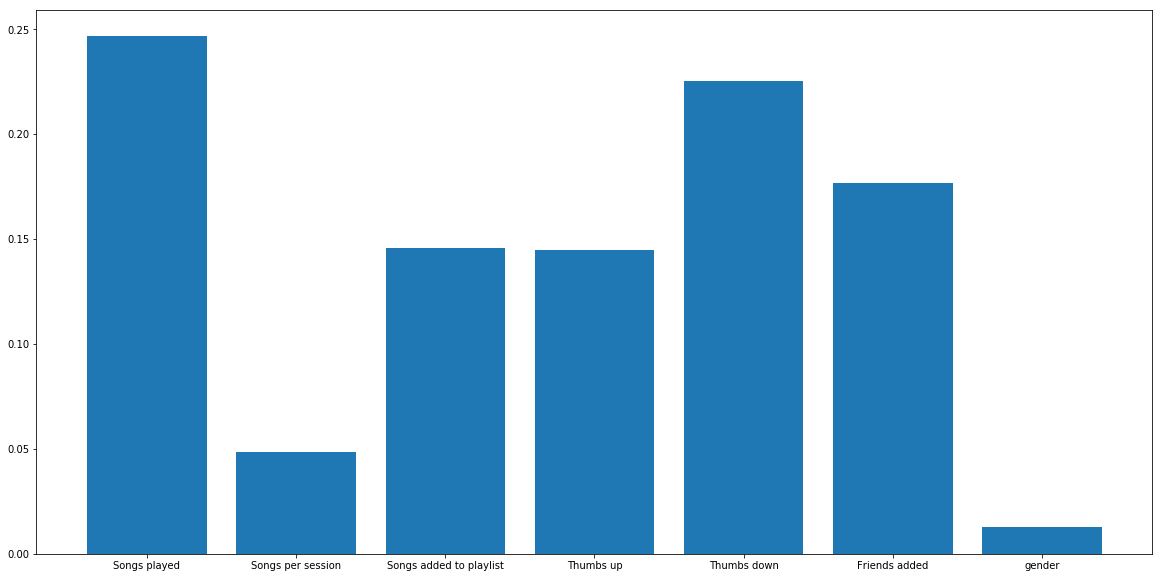

In [379]:
x = np.arange(7)
features = ['Songs played','Songs per session','Songs added to playlist','Thumbs up','Thumbs down','Friends added','gender']
coefficients = list(tuned_model.bestModel.featureImportances.values)

fig, ax = plt.subplots(figsize=(20,10))
plt.bar(x, coefficients)
plt.xticks(x, (features))
plt.show()

We can see here that songs played and thumbs down seem particularly strong attributes. Negative sentiment as expressed through 'thumbs down' appears more predictive than 'thumbs up'. 

Songs per session, curiously, is not very important - even though other song attributes are. 

Gender adds some signal to the model, but not a great deal. This is perhaps not surprising given the intuition built up from the EDA earlier on, which also suggested it to be only relatively loosely associated with churn.

## 6. Results

We found we're able to reach an F1-Score of ~76% using our tuned random forest model. This is a good outcome, and one that is likely to improve if we move beyond this prototyping data set to make use of a large training set.

We found that a base random forest model was more effective than a logistic regression model. Furthermore, we found that in tuning the random forest model, a relatively low max depth and number of trees was most effective (five of each)

Among our individual features, we found that songs played and thumbs down are the strongest predidctors of churn. The latter in particular is something quite easily actionable: if we were to see a high number of 'thumbs down' events from a given user, we may want to consider taking action to reduce churn in advance.

## 7. Conclusion

#### 7.1 Summary

In summary, we have implemented an initial model to predict customer churn. We've performed initial data preparation, identified and built a number of useful features, and trained a model to make use of them. We've found a random forest model to be a reasonably good predictor, achieving an f1-score of ~80%+. 

#### 7.2 Reflections

Perhaps the most engaging aspect of this project was the chance to test out Spark and its associated ML capabilities. Though this was an initial exploration on a sample data set, in practice this problem may be tackled with far larger data sets in a scalable cloud environment (e.g. AWS).

The exploration aspect of this work was also interesting. We generated several ideas for features, explored them, and at times found counter-intuitive insights as to what features were more or less associated with the target variable.

#### 7.3 Improvement potential

There are multiple next steps we might pursue to refine this model further. 

First of all, additional features might be identified and built, beyond those we used here. For example, we might look at the duration of user sessions.

Second, further model types might be tested. While we reached a high performance level with a random forest model, other options might be even more performant. 

Next, we might extend the approach to other user activities. For example, perhaps we might look for a predictor of customers downgrading, which also has large economic implications.

Lastly, we could look to train a model on a larger dataset. This exploration provides a basis for doing this, and ultimately we might look to re-create this in a more scalable environment in the cloud to process large data sets and make use of Spark's full capabilities.